In [ ]:
!pip install transformers

In [ ]:
!pip install stop_words

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
#from pytorch_pretrained_bert import BertTokenizer, BertConfig
#from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
#torch.cuda.get_device_name(0)

In [ ]:
from google.colab import drive
drive.mount('drive', force_remount=True)

with open("/content/drive/My Drive/frames.csv") as dataset:
#with open("/content/drive/My Drive/frame_reduce.csv") as dataset:
  df = pd.read_csv(dataset)

df.head()

Mounted at drive


<ipython-input-83-2fe1cdfe5010>:6: DtypeWarning: Columns (8,10,15,21,27,33) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(dataset)


,id,frame_id,turn,text,author,intent_1,intent_2,NO_RESULT,HEARMORE,REJECTED,...,max_duration,count_amenities,theatre,dep_time_dst,str_date,n_adults,vicinity,end_date,dep_time_or,gst_rating
0,e2c0fc6c-2134-4891-8353-ef16d8412c9a,1,1,'I'd like to book a trip to Atlantis from Capr...,user,inform,inform,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,13-Aug,8,NaN,NaN,NaN,NaN
1,e2c0fc6c-2134-4891-8353-ef16d8412c9a,1,2,"'Hi...I checked a few options for you, and unf...",wizard,no_result,suggest,True,NaN,NaN,...,NaN,NaN,NaN,NaN,13-Aug,8,NaN,NaN,NaN,NaN
2,e2c0fc6c-2134-4891-8353-ef16d8412c9a,2,3,"'Yes, how about going to Neverland from Capric...",user,inform,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,13-Aug,5,NaN,NaN,NaN,NaN
3,e2c0fc6c-2134-4891-8353-ef16d8412c9a,2,4,'I checked the availability for this date and ...,wizard,no_result,suggest,True,NaN,NaN,...,NaN,NaN,NaN,NaN,13-Aug,5,NaN,NaN,NaN,NaN
4,e2c0fc6c-2134-4891-8353-ef16d8412c9a,3,5,'I have no flexibility for dates... but I can ...,user,inform,inform,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,13-Aug,8,NaN,NaN,NaN,NaN


intent_1
1     8706
2     3043
3     2322
4     1148
5      749
6      695
7      537
8      511
9      357
10     307
17     221
11     194
12     179
13     137
14      85
15      82
16      58
18      17
19      13
Name: count, dtype: int64
19361


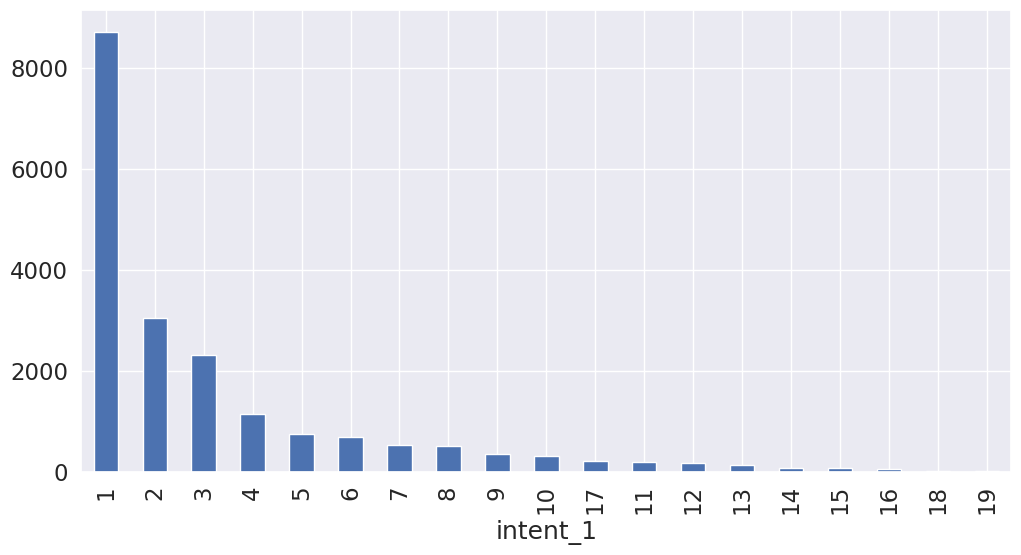

In [ ]:
print(df['intent_1'].value_counts())
df['intent_1'].value_counts().plot(kind='bar')

print(len(df))

In [ ]:
#replace intent_1 with value switch_frame with values from intent_2
df["intent_1"] = np.where(df["intent_1"] == "switch_frame", df["intent_2"], df["intent_1"])

#drop text with blank intent_1
df['intent_1'].replace('', np.nan, inplace=True)
df.dropna(subset=['intent_1'], inplace=True)

#use only text and intent_1 for training
columns = ['text','intent_1']
df = df[columns]

print(df['intent_1'].value_counts())

print(len(df))

display(df)

intent_1
inform             8706
request            3043
offer              2322
no_result          1148
thankyou            749
suggest             695
affirm              537
greeting            511
negate              357
confirm             307
moreinfo            221
request_compare     194
request_alts        179
goodbye             137
you_are_welcome      85
sorry                82
canthelp             58
hearmore             17
reject               13
Name: count, dtype: int64
19361


,text,intent_1
0,'I'd like to book a trip to Atlantis from Capr...,inform
1,"'Hi...I checked a few options for you, and unf...",no_result
2,"'Yes, how about going to Neverland from Capric...",inform
3,'I checked the availability for this date and ...,no_result
4,'I have no flexibility for dates... but I can ...,inform
...,...,...
19981,"'Yup it's from the 12th to the 25th, and it wi...",inform
19982,"'Ok perfect, book me!'",inform
19983,'Consider it done! Have a good trip :slightly_...,inform
19984,'Thanks!',thankyou


In [ ]:
#df['category'] = df["category"].map({'inform':0,'request':1,'offer':2,'switch_frame':3,'no_result':4,'thankyou':5,'suggest':6,'affirm':7,'greeting':8,'negate':9,'confirm':10,'request_compare':11,'request_alts':12,'goodbye':13,'you_are_welcome':14,'sorry':15,'canthelp':16,'moreinfo':17,'hearmore':18,'reject':19})
df["intent_1"].replace(["inform","request","offer","no_result","thankyou","suggest","affirm","greeting","negate","confirm","request_compare","request_alts","goodbye","you_are_welcome","sorry","canthelp","moreinfo","hearmore","reject"],[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], inplace=True)


<ipython-input-86-75c1009a334d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["intent_1"].replace(["inform","request","offer","no_result","thankyou","suggest","affirm","greeting","negate","confirm","request_compare","request_alts","goodbye","you_are_welcome","sorry","canthelp","moreinfo","hearmore","reject"],[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], inplace=True)


In [ ]:
display(df['intent_1'])

0         1
1         4
2         1
3         4
4         1
         ..
19981     1
19982     1
19983     1
19984     5
19985    14
Name: intent_1, Length: 19361, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

# using the train test split function
X_train, X_test, y_train, y_test = train_test_split(df['text'],df['intent_1'],
                                   random_state=104,
                                   test_size=0.25,
                                   shuffle=True)

# printing out train and test sets

print('X_train : ')
print(X_train.head())
print('')
print('X_test : ')
print(X_test.head())
print('')
print('y_train : ')
print(y_train.head())
print('')
print('y_test : ')
print(y_test.head())


X_train : 
3017                  'And how many people will be going?'
8662     'Please find me a package for 22 adults from K...
17720    'How many of you will be going and for how long?'
11381          'what do other guests think of this place?'
7719        'hmm ok, ok. anything impressive in Brasilia?'
Name: text, dtype: object

X_test : 
13564            'We have 6 adults looking to book a trip'
2195     'Your vacation has been booked. Enjoy your stay!'
10616           'What would be the price difference here?'
1178     'regal resort seems great! ca we upgrade that ...
19136    'Hey bot. I got all the money there is in the ...
Name: text, dtype: object

y_train : 
3017     2
8662     1
17720    2
11381    2
7719     1
Name: intent_1, dtype: int64

y_test : 
13564    1
2195     1
10616    2
1178     1
19136    1
Name: intent_1, dtype: int64


In [ ]:
sentences = X_train
labels = list(y_train)

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
#MAX_LEN = 128
MAX_LEN = 50

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

print("Length of input_ids:", len(input_ids))
print("Length of attention_masks:", len(attention_masks))
print("Length of labels:", len(labels))

Original:  'I'd like to book a trip to Atlantis from Caprica on Saturday, August 13, 2016 for 8 adults. I have a tight budget of 1700.'
Token IDs: tensor([ 101, 1005, 1998, 2129, 2116, 2111, 2097, 2022, 2183, 1029, 1005,  102,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0])
Length of input_ids: 14520
Length of attention_masks: 14520
Length of labels: 14520


In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

11,616 training samples
2,904 validation samples


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it
# here. For fine-tuning BERT on a specific task, the authors recommend a batch
# size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 20, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
    return_dict=False
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

optimizer = AdamW(model.parameters(),
                  lr = 1e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4.
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random
import numpy as np

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.

        loss, logits = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        #print(loss, logits, b_input_ids)
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 4 ========
Training...
  Batch    40  of    726.    Elapsed: 0:00:07.
  Batch    80  of    726.    Elapsed: 0:00:13.
  Batch   120  of    726.    Elapsed: 0:00:20.
  Batch   160  of    726.    Elapsed: 0:00:26.
  Batch   200  of    726.    Elapsed: 0:00:33.
  Batch   240  of    726.    Elapsed: 0:00:39.
  Batch   280  of    726.    Elapsed: 0:00:46.
  Batch   320  of    726.    Elapsed: 0:00:52.
  Batch   360  of    726.    Elapsed: 0:00:59.
  Batch   400  of    726.    Elapsed: 0:01:05.
  Batch   440  of    726.    Elapsed: 0:01:11.
  Batch   480  of    726.    Elapsed: 0:01:17.
  Batch   520  of    726.    Elapsed: 0:01:24.
  Batch   560  of    726.    Elapsed: 0:01:30.
  Batch   600  of    726.    Elapsed: 0:01:37.
  Batch   640  of    726.    Elapsed: 0:01:43.
  Batch   680  of    726.    Elapsed: 0:01:49.
  Batch   720  of    726.    Elapsed: 0:01:56.

  Average training loss: 1.34
  Training epcoh took: 0:01:57

Running Validation...
  Accuracy: 0.78
  Validat

In [ ]:
import pandas as pd

# Display floats with two decimal places.
#pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.341103,0.839171,0.778846,0:01:57,0:00:09
2,0.739465,0.677541,0.806662,0:01:56,0:00:09
3,0.572912,0.629690,0.817651,0:01:56,0:00:09
4,0.492702,0.623140,0.822802,0:01:56,0:00:09


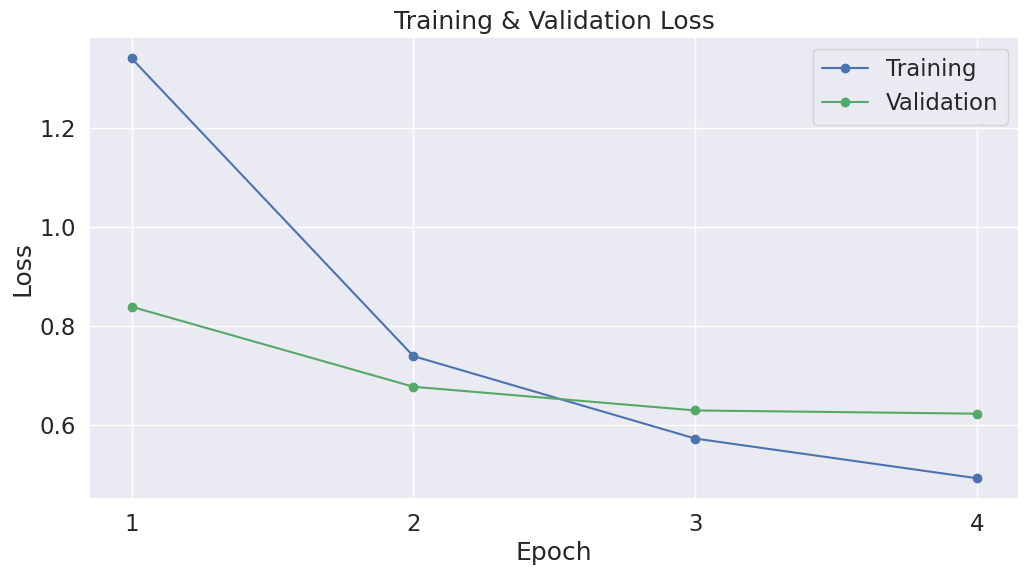

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
# Create sentence and label lists
sentences = X_test
labels = list(y_test)

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )


    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.
batch_size = 32

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 4,841 test sentences...
    DONE.


In [ ]:
from functools import reduce
scores = reduce(lambda x,y: x+y,[list(map(np.argmax,p)) for p in predictions])
labels = reduce(lambda x,y: list(x) + list(y), true_labels)

from sklearn.metrics import accuracy_score, classification_report
accuracy_score(scores, labels)

0.8087172071885974

In [ ]:
print(classification_report(scores, labels))

              precision    recall  f1-score   support

           1       0.88      0.86      0.87      2183
           2       0.93      0.83      0.88       870
           3       0.87      0.76      0.81       686
           4       0.95      0.78      0.86       348
           5       0.91      0.76      0.83       212
           6       0.52      0.59      0.55       143
           7       0.67      0.65      0.66       137
           8       0.73      0.77      0.75       129
           9       0.11      0.38      0.17        24
          10       0.34      0.68      0.46        44
          11       0.00      0.00      0.00         0
          12       0.15      1.00      0.26        10
          13       0.12      0.67      0.20         6
          14       0.48      1.00      0.65        13
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0
          17       0.50      0.78      0.61        36
          18       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
torch.save(model.state_dict(), "model_default_dataset")